In [1]:
%matplotlib notebook
from DataGenerator import * 
from network import LocalNet, LocalNetOutputMultiRuleModel
from BrainNet import BrainNet
from LocalNetBase import Options, UpdateScheme
import matplotlib.pyplot as plt
from train import train_local_rule, train_vanilla, train_given_rule
import numpy as np
from train import evaluate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4)

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Lambda(lambda x : x.flatten().double())])
trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=True)

In [3]:
options = Options(
                 gd_output = False,
                 gd_input = False,
                 use_graph_rule = True, 
                 use_input_rule = False,
                 use_output_rule = True,
                 gd_output_rule = False,
                 gd_graph_rule = False,
                 additive_rule = False)

scheme = UpdateScheme(
            cross_entropy_loss = True, 
            mse_loss = False, 
            update_misclassified_only = True,
            update_all_edges = False
        )

In [4]:
options.use_graph_rule = True
options.additive_rule = False 

meta_model = LocalNetOutputMultiRuleModel(784, 10, num_v = 200, p = .5, cap = 100, rounds = 2, step_sz=1e-2, options = options)
# meta_model.input_weights = torch.ones_like(meta_model.input_weights)
meta_model.set_output_rule(torch.tensor([[-1,1],[1,-1],[-1,1],[1,-1],[-1,1],[1,-1],[-1,1],[1,-1]]))
optimizer = torch.optim.Adam(meta_model.graph_rule_model.parameters(), lr=1e-2)
losses = []

/home/max/Projects/Learning Plasticity Rules/network.py:229: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629401553/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  self.edges = (self.graph > 0).nonzero()


In [5]:
for i in range(1):
    for j, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()

        loss = meta_model(inputs, labels, 1, 1)
        loss.backward()
        optimizer.step()
        losses += [loss.item()]
        if j % 1 == 0:
            if j % 10 == 0:
                n_correct = 0
                with torch.no_grad():
                    for inputs, labels in testloader:
                        outputs = meta_model.forward_pass(inputs)
                        n_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
                print('Local Net Test Accuracy: {:.3f}%'.format(n_correct / len(testset) * 100))
            print('Epoch {:d} Batch {:d}: {:.3f}'.format(i, j, loss.item()))

Local Net Test Accuracy: 42.900%
Epoch 0 Batch 0: 8895.212
Epoch 0 Batch 1: 8221.607
Epoch 0 Batch 2: 10060.113
Epoch 0 Batch 3: 3402.280
Epoch 0 Batch 4: 4487.323
Epoch 0 Batch 5: 2849.094
Epoch 0 Batch 6: 3507.562
Epoch 0 Batch 7: 5226.544
Epoch 0 Batch 8: 3130.433
Epoch 0 Batch 9: 3894.425
Local Net Test Accuracy: 39.770%
Epoch 0 Batch 10: 2517.657
Epoch 0 Batch 11: 2600.013
Epoch 0 Batch 12: 1507.363
Epoch 0 Batch 13: 1718.721
Epoch 0 Batch 14: 1352.545
Epoch 0 Batch 15: 1302.182
Epoch 0 Batch 16: 1251.915
Epoch 0 Batch 17: 1113.675
Epoch 0 Batch 18: 1469.694
Epoch 0 Batch 19: 1267.252
Local Net Test Accuracy: 46.490%
Epoch 0 Batch 20: 982.163
Epoch 0 Batch 21: 1064.933
Epoch 0 Batch 22: 651.042
Epoch 0 Batch 23: 589.847
Epoch 0 Batch 24: 643.524
Epoch 0 Batch 25: 383.541
Epoch 0 Batch 26: 450.352
Epoch 0 Batch 27: 305.491
Epoch 0 Batch 28: 476.159
Epoch 0 Batch 29: 528.309
Local Net Test Accuracy: 41.590%
Epoch 0 Batch 30: 484.329
Epoch 0 Batch 31: 328.256
Epoch 0 Batch 32: 305.72

Epoch 0 Batch 282: 5.073
Epoch 0 Batch 283: 4.877
Epoch 0 Batch 284: 4.769
Epoch 0 Batch 285: 4.234
Epoch 0 Batch 286: 11.295
Epoch 0 Batch 287: 5.597
Epoch 0 Batch 288: 9.573
Epoch 0 Batch 289: 5.943
Local Net Test Accuracy: 49.190%
Epoch 0 Batch 290: 4.222
Epoch 0 Batch 291: 4.704
Epoch 0 Batch 292: 7.427
Epoch 0 Batch 293: 2.764
Epoch 0 Batch 294: 5.143
Epoch 0 Batch 295: 7.340
Epoch 0 Batch 296: 3.469
Epoch 0 Batch 297: 7.005
Epoch 0 Batch 298: 4.534
Epoch 0 Batch 299: 11.680


In [6]:
meta_model1 = LocalNetOutputMultiRuleModel(784, 10, num_v = 1000, p = .5, cap = 500, rounds = 2, step_sz=1e-3, options = options)

meta_model1.set_output_rule(torch.tensor([[-1,1],[1,-1],[-1,1],[1,-1],[-1,1],[1,-1],[-1,1],[1,-1]]))
meta_model1.graph_rule_model = meta_model.graph_rule_model

meta_model1.graph_weights = torch.zeros_like(meta_model1.graph_weights)
meta_model1.output_weights = torch.zeros_like(meta_model1.output_weights)

meta_model1.step_sz = 1e-5
cnt = 0

test_acc = []
with torch.no_grad():
    for i in range(1):
        for j, data in enumerate(trainloader):
            cnt += 1
            inputs, labels = data
            if i == 0 and j == 0:
                continue_ = False
            else:
                continue_ = True
            continu_ = True
            loss = meta_model1(inputs, labels, 1, 1, continue_=continue_)
            losses += [loss.item()]

            if j % 1 == 0:
                print('{:d} {:d}: {:.3f}'.format(i, j, loss.item()))


                if j % 10 == 0:
                    local_correct = 0
                    with torch.no_grad():
                        for inputs, labels in testloader:
                            outputs = meta_model1.forward_pass(inputs)
                            local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
                            test_acc.append(local_correct / len(testset) * 100)
                    print('Local Net Train Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))


0 0: 500.623
Local Net Train Accuracy: 28.550%
0 1: 281.533
0 2: 377.539
0 3: 196.055
0 4: 163.709
0 5: 510.626
0 6: 215.587
0 7: 211.251
0 8: 318.586
0 9: 307.212
0 10: 428.933
Local Net Train Accuracy: 58.340%
0 11: 534.181
0 12: 253.296
0 13: 401.209
0 14: 214.346
0 15: 477.167
0 16: 219.454
0 17: 195.099
0 18: 214.909
0 19: 294.496
0 20: 110.595
Local Net Train Accuracy: 73.480%
0 21: 187.211
0 22: 205.807
0 23: 355.840
0 24: 245.728
0 25: 115.018
0 26: 326.756
0 27: 220.944
0 28: 171.915
0 29: 126.709
0 30: 209.147
Local Net Train Accuracy: 70.230%
0 31: 121.014
0 32: 197.963
0 33: 220.604
0 34: 252.490
0 35: 179.338
0 36: 373.458
0 37: 110.783
0 38: 243.928
0 39: 167.951
0 40: 229.049
Local Net Train Accuracy: 75.620%
0 41: 77.350
0 42: 162.950
0 43: 171.793
0 44: 161.416
0 45: 165.093
0 46: 121.626
0 47: 285.011
0 48: 139.790
0 49: 140.087
0 50: 280.706
Local Net Train Accuracy: 71.830%
0 51: 288.842
0 52: 201.541
0 53: 166.270
0 54: 518.685
0 55: 102.524
0 56: 246.411
0 57: 143

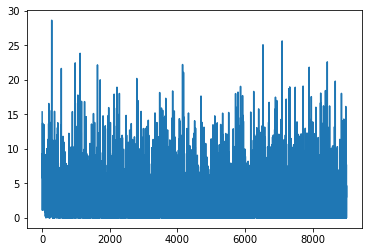

In [ ]:
fig, ax = plt.subplots()
ax.plot(losses)

In [11]:
local_net = meta_model

local_correct = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = local_net.forward_pass(inputs)
        local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('Local Net Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))

Local Net Test Accuracy: 37.920%


In [9]:
local_net = meta_model1
local_correct = 0

with torch.no_grad():
    for inputs, labels in trainloader:
        outputs = local_net.forward_pass(inputs)
        local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('Local Net Train Accuracy: {:.3f}%'.format(local_correct / len(trainset) * 100))

Local Net Train Accuracy: 75.177%


In [41]:
inputs, labels = iter(trainloader).next()
with torch.no_grad():
    outputs = local_net.forward_pass(inputs)
    local_correct = np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
local_correct / 200 * 100

71.0

<IPython.core.display.Javascript object>


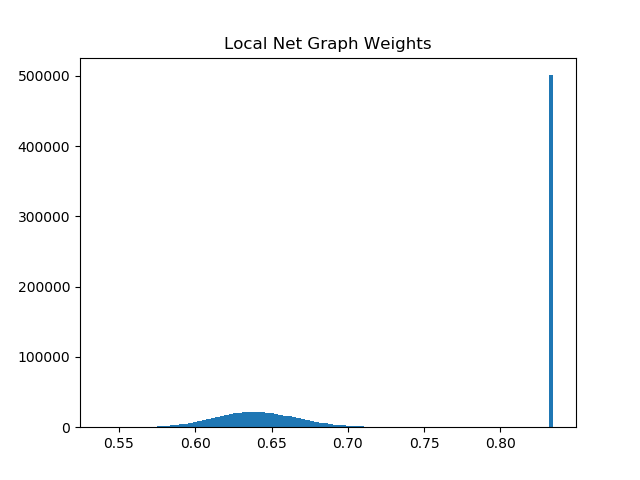

In [14]:
fig, ax = plt.subplots()
ax.hist(local_net.graph_weights.detach().numpy().flatten(), bins=100)
ax.set_title('Local Net Graph Weights')
plt.savefig("local_net_graph_weights__n=200_t=3.png")

<IPython.core.display.Javascript object>


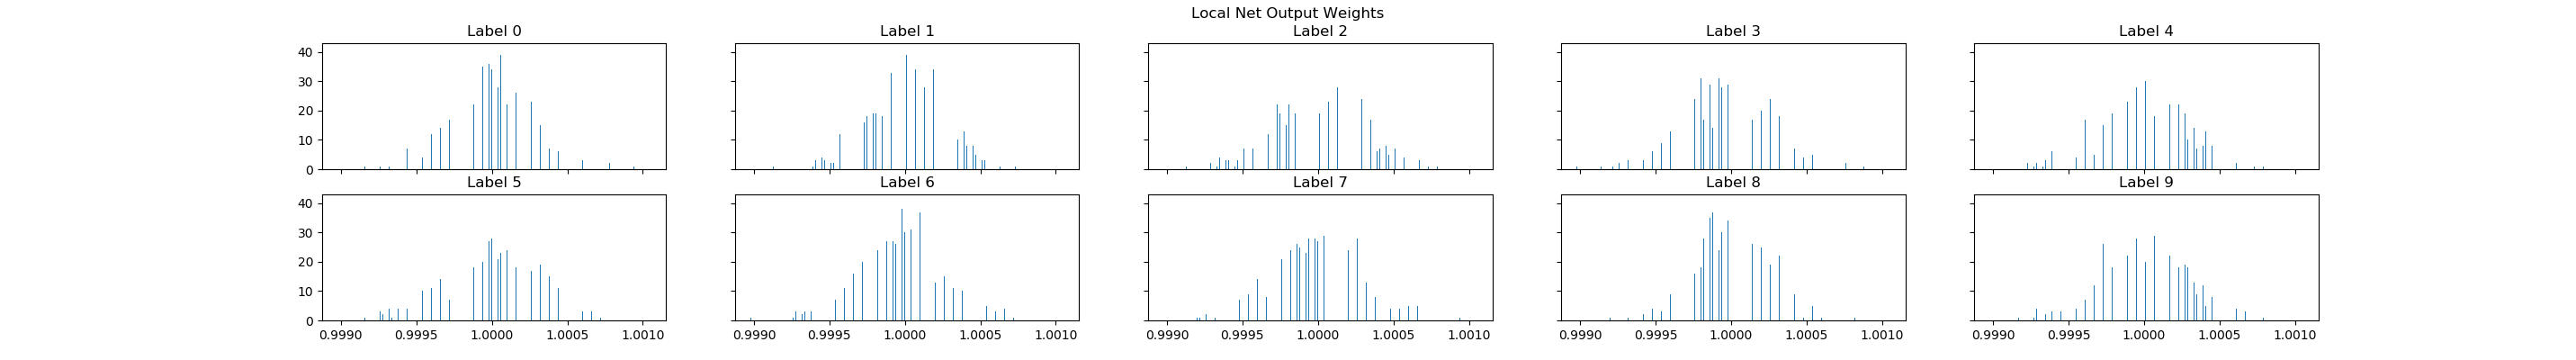

In [15]:
weights = local_net.output_weights.numpy()
fig, axes = plt.subplots(2, 5, figsize=(16, 4), sharex=True, sharey=True)
for i in range(2):
    for j, ax in enumerate(axes[i]):
        axes[i, j].hist(weights[i*5 + j], bins=1000, range=(weights.min(), weights.max()))
        axes[i, j].set_title('Label {}'.format(i*5 + j))
fig.suptitle('Local Net Output Weights')
plt.savefig("local_net_output_weights_n=200_t=3.png")

In [10]:
gd_net = BrainNet(784, 10, num_v = 1000, p = .5, cap = 500, rounds = 2, gd_output = True, gd_graph=True)
gd_net.input_layer = local_net.input_layer
gd_net.input_weights = local_net.input_weights
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gd_net.parameters(), lr=1e-3)

In [11]:
for i in range(40):
    for j, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = gd_net.forward_pass(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if j % 100 == 0:
            print('{:d} {:d}: {:.3f}'.format(i, j, loss.item()))
            gd_correct = 0

            with torch.no_grad():
                for inputs, labels in testloader:
                    outputs = gd_net.forward_pass(inputs)
                    gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
            print('GD Net Test Accuracy: {:.3f}%'.format(gd_correct / len(testset) * 100))

0 0: 194369.316
GD Net Test Accuracy: 8.560%
0 100: 12448.959
GD Net Test Accuracy: 69.660%
0 200: 10477.403
GD Net Test Accuracy: 73.000%
1 0: 5500.131
GD Net Test Accuracy: 76.540%
1 100: 4776.391
GD Net Test Accuracy: 77.650%
1 200: 5543.313
GD Net Test Accuracy: 77.780%
2 0: 3814.218
GD Net Test Accuracy: 79.630%
2 100: 3790.581
GD Net Test Accuracy: 79.870%
2 200: 4791.725
GD Net Test Accuracy: 79.010%
3 0: 2835.369
GD Net Test Accuracy: 80.360%
3 100: 4683.204
GD Net Test Accuracy: 80.790%
3 200: 4028.988
GD Net Test Accuracy: 81.030%
4 0: 4785.926
GD Net Test Accuracy: 81.670%
4 100: 2497.376
GD Net Test Accuracy: 80.240%
4 200: 2929.170
GD Net Test Accuracy: 81.450%
5 0: 1817.887
GD Net Test Accuracy: 81.020%
5 100: 1856.845
GD Net Test Accuracy: 81.740%
5 200: 2270.683
GD Net Test Accuracy: 82.690%
6 0: 2009.378
GD Net Test Accuracy: 82.560%
6 100: 1828.999
GD Net Test Accuracy: 81.910%
6 200: 2091.852
GD Net Test Accuracy: 82.620%
7 0: 1054.248
GD Net Test Accuracy: 83.090%
7

In [12]:
gd_correct = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = gd_net.forward_pass(inputs)
        gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('GD Net Test Accuracy: {:.3f}%'.format(gd_correct / len(testset) * 100))

GD Net Test Accuracy: 85.300%


<IPython.core.display.Javascript object>


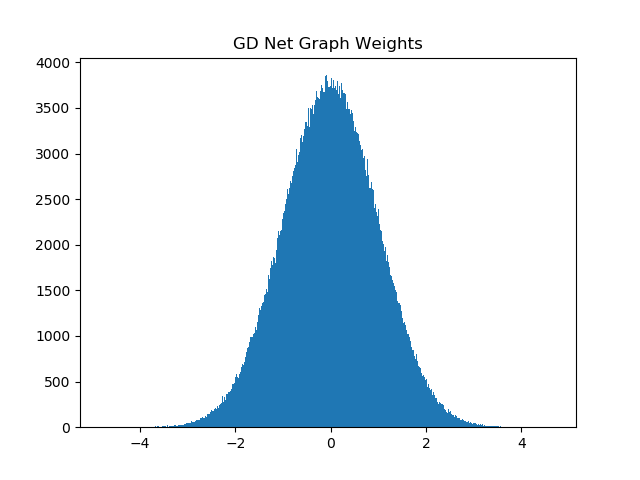

Text(0.5, 1.0, 'GD Net Graph Weights')

In [19]:
fig, ax = plt.subplots()
ax.hist(gd_net.graph_weights.detach().numpy().flatten(), bins=1000)
ax.set_title('GD Net Graph Weights')

<IPython.core.display.Javascript object>


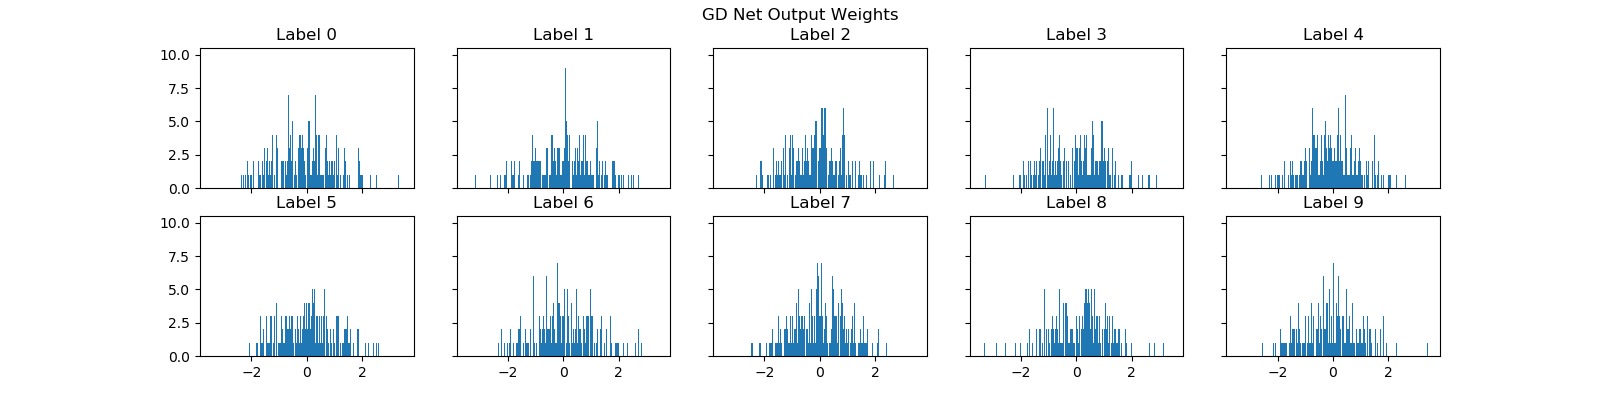

Text(0.5, 0.98, 'GD Net Output Weights')

In [20]:
weights = gd_net.output_weights.detach().numpy()
fig, axes = plt.subplots(2, 5, figsize=(16, 4), sharex=True, sharey=True)
for i in range(2):
    for j, ax in enumerate(axes[i]):
        axes[i, j].hist(weights[i*5 + j], bins=1000, range=(weights.min(), weights.max()))
        axes[i, j].set_title('Label {}'.format(i*5 + j))
fig.suptitle('GD Net Output Weights')

In [32]:
# Adversarial data-set with epsilon ball 

from AdversarialExamples import adversarial_example

from random import randrange


dist = np.zeros((10, 10))
cnt = np.zeros((10, 10))

dist_gd = np.zeros((10, 10))
cnt_gd = np.zeros((10, 10))

gd_net_adv_on_local_train_full = []
local_adv_on_local_train_full = []

gd_net_adv_on_gd_train_full = []
local_adv_on_gd_train_full = []

for EPS in [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]: 
    print("EPS: ", EPS)
    perturbed_data_x_local = []
    perturbed_data_y_local = []

    perturbed_data_x_gd = []
    perturbed_data_y_gd = []

    c = 0
    for j, data in enumerate(trainloader):
        if c >= 1000: break
        X, y = data
#         print(y.shape)
        for _x, _y in zip(X, y):
            # LOCAL NET
            prediction = torch.argmax(local_net.forward_pass(_x.unsqueeze(0))).item()
            if prediction != _y : 
                continue 
            # GD 
            prediction = torch.argmax(gd_net.forward_pass(_x.unsqueeze(0))).item()
            if prediction != _y : 
                continue 

            # print(c)
            c += 1
#             print(c)


            yy = _y
            while yy == _y: 
                yy = randrange(10)

                # LOCAL NET
                final = adversarial_example(_x.unsqueeze(0), torch.tensor([yy]).long(), local_net.forward_pass, EPS)
                dist[_y][yy] += np.linalg.norm(final.detach().numpy() - _x.numpy())
                cnt[_y][yy] += 1

                perturbed_data_x_local.append(final)
                perturbed_data_y_local.append(_y)

                # GD 
                final = adversarial_example(_x.unsqueeze(0), torch.tensor([yy]).long(), gd_net.forward_pass, EPS)
                dist_gd[_y][yy] += np.linalg.norm(final.detach().numpy() - _x.numpy())
                cnt_gd[_y][yy] += 1

                perturbed_data_x_gd.append(final)
                perturbed_data_y_gd.append(_y)


    print("GD Net")

    gd_correct = 0
    with torch.no_grad():
        for inputs, labels in zip(perturbed_data_x_gd, perturbed_data_y_gd):
            outputs = gd_net.forward_pass(inputs)
            gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
    print('GD-Adversarial Accuracy: {:.3f}%'.format(gd_correct / len(perturbed_data_y_gd) * 100))
    gd_net_adv_on_gd_train_full.append(gd_correct / len(perturbed_data_y_gd))

    gd_correct = 0
    with torch.no_grad():
        for inputs, labels in zip(perturbed_data_x_local, perturbed_data_y_local):
            outputs = gd_net.forward_pass(inputs)
            gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
    print('LocalNet-Adversarial Accuracy: {:.3f}%'.format(gd_correct / len(perturbed_data_y_local) * 100))
    local_adv_on_gd_train_full.append(gd_correct / len(perturbed_data_y_local))

    print("Local Net")

    gd_correct = 0
    with torch.no_grad():
        for inputs, labels in zip(perturbed_data_x_gd, perturbed_data_y_gd):
            outputs = local_net.forward_pass(inputs)
            gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
    print('GD-Adversarial Accuracy: {:.3f}%'.format(gd_correct / len(perturbed_data_y_gd) * 100))
    gd_net_adv_on_local_train_full.append(gd_correct / len(perturbed_data_y_gd))

    gd_correct = 0
    with torch.no_grad():
        for inputs, labels in zip(perturbed_data_x_local, perturbed_data_y_local):
            outputs = local_net.forward_pass(inputs)
            gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
    print('LocalNet-Adversarial Accuracy: {:.3f}%'.format(gd_correct / len(perturbed_data_y_local) * 100))
    local_adv_on_local_train_full.append(gd_correct / len(perturbed_data_y_local))


EPS:  0
GD Net
GD-Adversarial Accuracy: 99.582%
LocalNet-Adversarial Accuracy: 99.582%
Local Net
GD-Adversarial Accuracy: 95.649%
LocalNet-Adversarial Accuracy: 95.649%
EPS:  0.5
GD Net
GD-Adversarial Accuracy: 58.145%
LocalNet-Adversarial Accuracy: 98.830%
Local Net
GD-Adversarial Accuracy: 93.985%
LocalNet-Adversarial Accuracy: 94.319%
EPS:  1
GD Net
GD-Adversarial Accuracy: 19.679%
LocalNet-Adversarial Accuracy: 97.720%
Local Net
GD-Adversarial Accuracy: 93.666%
LocalNet-Adversarial Accuracy: 92.990%
EPS:  1.5
GD Net
GD-Adversarial Accuracy: 10.823%
LocalNet-Adversarial Accuracy: 94.978%
Local Net
GD-Adversarial Accuracy: 91.861%
LocalNet-Adversarial Accuracy: 90.216%
EPS:  2
GD Net
GD-Adversarial Accuracy: 8.987%
LocalNet-Adversarial Accuracy: 94.449%
Local Net
GD-Adversarial Accuracy: 93.216%
LocalNet-Adversarial Accuracy: 89.075%
EPS:  2.5
GD Net
GD-Adversarial Accuracy: 9.806%
LocalNet-Adversarial Accuracy: 91.801%
Local Net
GD-Adversarial Accuracy: 94.421%
LocalNet-Adversarial 

KeyboardInterrupt: 

In [19]:
from AdversarialExamples import adversarial_example

from random import randrange

EPS = 3
original_data = []
perturbed_data_x_local = []
perturbed_data_y_local = []

perturbed_data_x_gd = []
perturbed_data_y_gd = []

c = 0
for j, data in enumerate(trainloader):
    if c >= 1000: break
    X, y = data
#         print(y.shape)
    for _x, _y in zip(X, y):
        # LOCAL NET
        prediction = torch.argmax(local_net.forward_pass(_x.unsqueeze(0))).item()
        if prediction != _y : 
            continue 
        # GD 
        prediction = torch.argmax(gd_net.forward_pass(_x.unsqueeze(0))).item()
        if prediction != _y : 
            continue 

        # print(c)
        c += 1
#             print(c)


        yy = _y
        while yy == _y: 
            yy = randrange(10)

            # LOCAL NET
            final = adversarial_example(_x.unsqueeze(0), torch.tensor([yy]).long(), local_net.forward_pass, EPS)

            perturbed_data_x_local.append(final)
            perturbed_data_y_local.append(_y)

            # GD 
            final = adversarial_example(_x.unsqueeze(0), torch.tensor([yy]).long(), gd_net.forward_pass, EPS)
            perturbed_data_x_gd.append(final)
            perturbed_data_y_gd.append(_y)
            
            original_data += [_x]

<IPython.core.display.Javascript object>


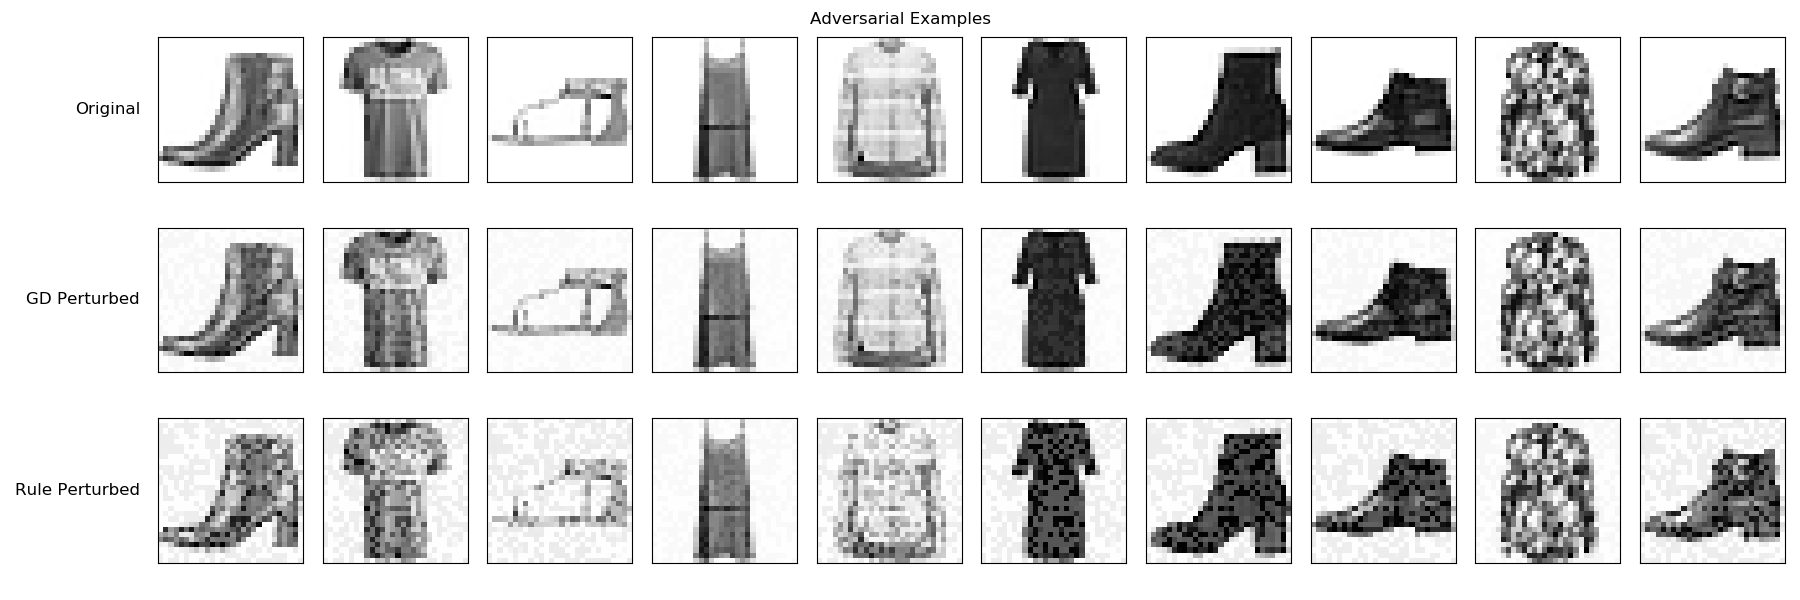

Text(0.5, 0.98, 'Adversarial Examples')

In [20]:
fig, axes = plt.subplots(3, 10, figsize=(18, 6))
for i in range(0,10):
    k = 0
    if i == 0: 
        k = 1
    axes[0,i].imshow(original_data[i].reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
    axes[1,i].imshow(perturbed_data_x_gd[i].detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
    axes[2,i].imshow(perturbed_data_x_local[i].detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
    axes[0,i].set_xticks([])
    axes[1,i].set_xticks([])
    axes[2,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].set_yticks([])
    axes[2,i].set_yticks([])
rows = ['Original', 'GD Perturbed', 'Rule Perturbed']
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
fig.tight_layout()
fig.suptitle('Adversarial Examples')

<IPython.core.display.Javascript object>


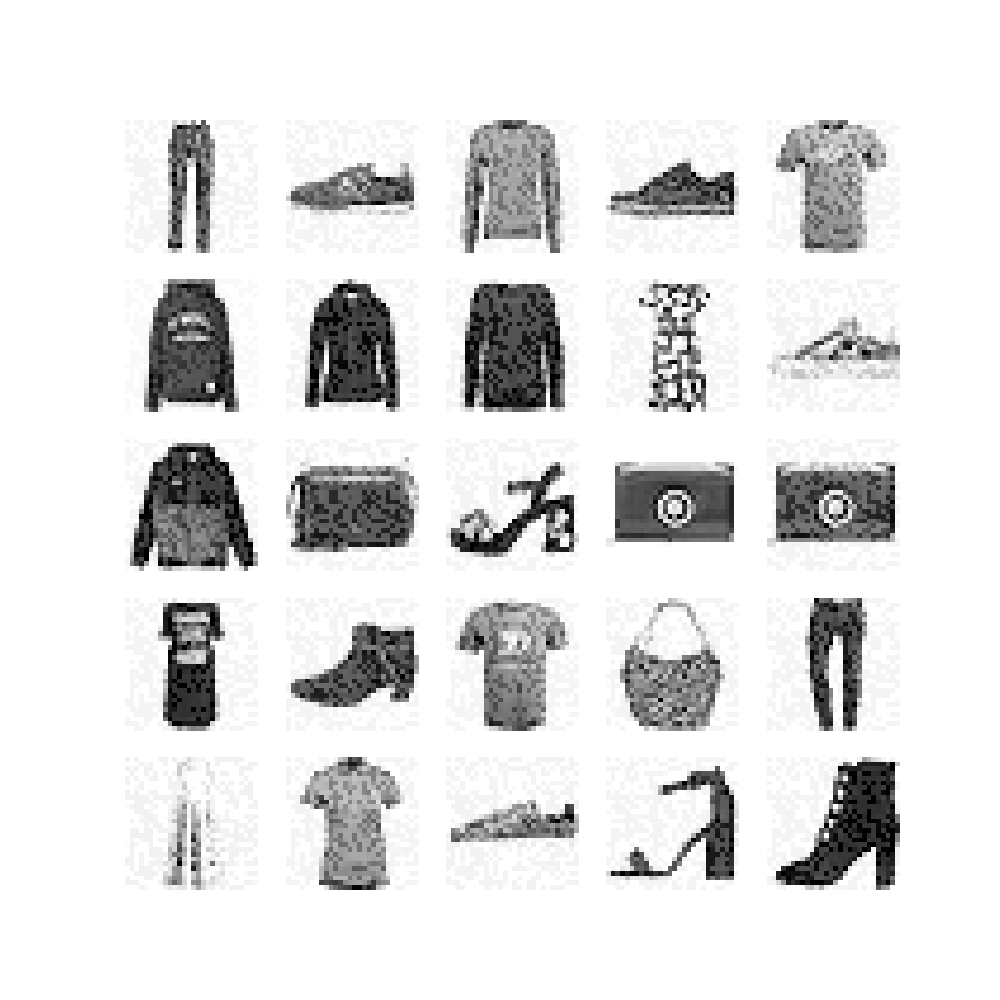

In [37]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))
for i in range(5):
    for j, ax in enumerate(axes[i]):
        ax.imshow(perturbed_data_x_local[5 * i + j].detach().numpy().reshape(28, 28), cmap='Greys')
        ax.set_axis_off()

<IPython.core.display.Javascript object>


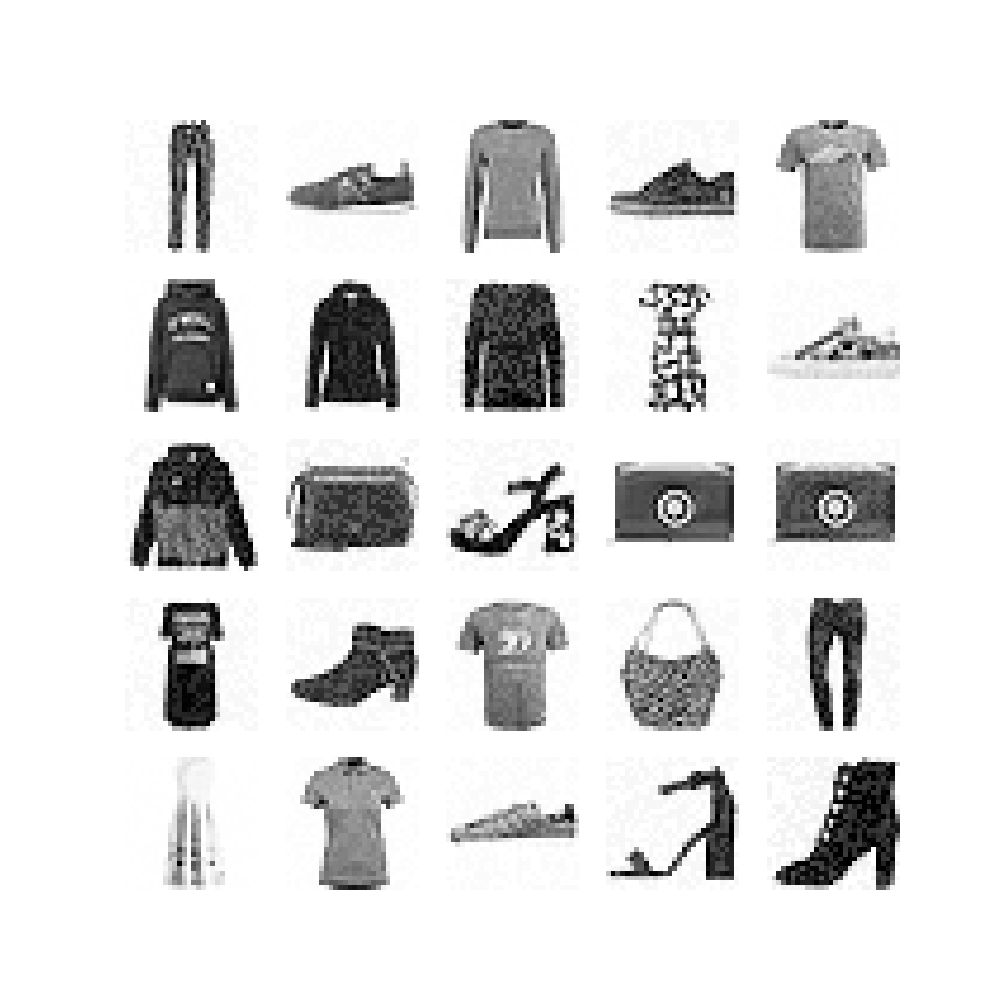

In [38]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))
for i in range(5):
    for j, ax in enumerate(axes[i]):
        ax.imshow(perturbed_data_x_gd[5 * i + j].detach().numpy().reshape(28, 28), cmap='Greys')
        ax.set_axis_off()

In [ ]:
fig.clear()
ts = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
plt.plot(ts, local_adv_on_local_train, label = "Rule Learning vs. Rule adversary")
plt.plot(ts, gd_net_adv_on_gd_train, label = "GD Learning vs. GD adversary")
plt.ylabel("Accuracy")
plt.xlabel("epsilon")
# plt.title("Accuracy against perturbed examples in epsilon-ball (T=3)")
# plt.legend()
# plt.savefig("acc_same_adv_t=3.png")

Text(0.5, 1.0, 'Accuracy against perturbed examples in epsilon-ball (T=3)')

In [ ]:
fig.clear()
ts = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
plt.plot(ts, local_adv_on_local_train, label = "Rule Learning vs. Rule adversary")
plt.plot(ts, gd_net_adv_on_gd_train, label = "GD Learning vs. GD adversary")
plt.ylabel("Accuracy")
plt.xlabel("epsilon")

ts = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
plt.plot(ts, local_adv_on_gd_train, label = "GD Learning vs. Rule adversary")
plt.plot(ts, gd_net_adv_on_local_train, label = "Rule Learning vs. GD adversary")
plt.ylabel("Accuracy")
plt.xlabel("epsilon")
plt.title("Accuracy against perturbed examples in epsilon-ball (T=3)")
plt.legend()
plt.savefig("acc_adverarial_t=3_including_incorrect_initial.png")

In [ ]:
local_adv_on_local_train

[0.9510729613733906,
 0.9433399602385686,
 0.9088235294117647,
 0.8791208791208791,
 0.8582541054451167,
 0.8238805970149253,
 0.7521514629948365,
 0.7222222222222222]

In [ ]:
fig.clear()
ts = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
plt.plot(ts, local_adv_on_local_train_full, label = "Rule Learning vs. Rule adversary")
plt.plot(ts, gd_net_adv_on_gd_train_full, label = "GD Learning vs. GD adversary")
plt.ylabel("Accuracy")
plt.xlabel("epsilon")

ts = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
plt.plot(ts, local_adv_on_gd_train_full, label = "GD Learning vs. Rule adversary")
plt.plot(ts, gd_net_adv_on_local_train_full, label = "Rule Learning vs. GD adversary")
plt.ylabel("Accuracy")
plt.xlabel("epsilon")
plt.title("Accuracy against perturbed examples in epsilon-ball (T=3)")
plt.legend()
plt.savefig("acc_adverarial_t_full=3.png")

In [ ]:

print("GD Net")

gd_correct = 0
with torch.no_grad():
    for inputs, labels in zip(perturbed_data_x_gd, perturbed_data_y_gd):
        outputs = gd_net.forward_pass(inputs)
        gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('GD-Adversarial Accuracy: {:.3f}%'.format(gd_correct / len(perturbed_data_y_gd) * 100))


gd_correct = 0
with torch.no_grad():
    for inputs, labels in zip(perturbed_data_x_local, perturbed_data_y_local):
        outputs = gd_net.forward_pass(inputs)
        gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('LocalNet-Adversarial Accuracy: {:.3f}%'.format(gd_correct / len(perturbed_data_y_local) * 100))


GD Net
GD-Adversarial Accuracy: 0.000%
LocalNet-Adversarial Accuracy: 74.563%


In [ ]:
print("Local Net")

gd_correct = 0
with torch.no_grad():
    for inputs, labels in zip(perturbed_data_x_gd, perturbed_data_y_gd):
        outputs = local_net.forward_pass(inputs)
        gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('GD-Adversarial Accuracy: {:.3f}%'.format(gd_correct / len(perturbed_data_y_gd) * 100))


gd_correct = 0
with torch.no_grad():
    for inputs, labels in zip(perturbed_data_x_local, perturbed_data_y_local):
        outputs = local_net.forward_pass(inputs)
        gd_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('LocalNet-Adversarial Accuracy: {:.3f}%'.format(gd_correct / len(perturbed_data_y_local) * 100))


Local Net
GD-Adversarial Accuracy: 92.233%
LocalNet-Adversarial Accuracy: 68.350%


In [ ]:
print(dist_gd / cnt_gd)

[[   nan 1.4742 1.1172 1.0688 1.3839 1.2284 1.1404 1.3927 1.2657 1.1052]
 [1.1786    nan 0.79   0.87   0.8048 1.0786 0.9368 0.7174 0.7496 0.8692]
 [1.1743 0.9625    nan 0.8738 1.239  1.576  1.1113 1.0218 0.8876 0.9485]
 [1.1081 1.1041 1.0097    nan 1.2997 0.7325 1.2756 1.2154 0.8823 1.0713]
 [1.2526 1.2568 1.0421 0.8411    nan 1.2717 1.0293 0.9491 0.7883 0.6198]
 [0.9333 1.1542 0.9968 0.5987 1.2647    nan 0.8595 1.0929 0.6767 0.9249]
 [0.9962 1.131  0.9523 1.1887 0.9276 0.8721    nan 1.1808 1.1126 1.3546]
 [1.1723 1.3056 0.9634 0.8849 1.1958 1.1165 1.3034    nan 1.0795 0.7939]
 [1.0301 1.1    0.7438 0.7201 1.0788 0.9137 1.3158 0.9925    nan 0.9138]
 [1.117  1.2118 1.0152 0.7706 0.7837 0.8695 1.2389 0.6921 0.7422    nan]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
print(dist / cnt)

[[   nan 4.0937 3.9423 4.0744 4.0686 3.6879 4.0855 3.7968 4.0763 4.0749]
 [4.0624    nan 3.1948 3.4526 4.0584 3.9578 4.0544 3.8705 3.4243 3.8454]
 [3.786  4.0282    nan 4.0417 4.0659 4.0946 4.0256 4.1036 3.9147 4.0815]
 [4.105  4.0996 4.0321    nan 4.1031 3.8718 4.0891 3.9154 3.8814 4.0808]
 [4.1022 4.1109 4.0786 4.0688    nan 4.0777 4.0498 3.9912 3.392  3.5294]
 [2.9864 4.1071 3.5623 3.5944 3.7146    nan 3.4441 4.0895 3.0517 4.1166]
 [4.0323 3.9937 3.528  4.0862 3.9973 3.4905    nan 4.0976 4.0171 4.1412]
 [4.0729 4.0748 3.9807 4.0597 4.0613 4.0906 4.0616    nan 4.0513 3.7783]
 [4.0816 4.0916 3.4896 3.6637 4.0859 3.8092 4.1094 3.5163    nan 4.0906]
 [4.1155 4.0603 3.6516 4.0832 3.0484 4.0073 4.0924 3.3954 3.454     nan]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
local_net_d = np.nan_to_num(dist / cnt)
gd_net_d = np.nan_to_num(dist_gd / cnt_gd)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
diff = local_net_d - gd_net_d
print(np.mean(diff))
print(diff)

2.576708801235186
[[0.     2.6194 2.8251 3.0056 2.6847 2.4595 2.9452 2.4041 2.8106 2.9697]
 [2.8838 0.     2.4047 2.5826 3.2537 2.8791 3.1175 3.1531 2.6746 2.9763]
 [2.6118 3.0657 0.     3.1679 2.827  2.5186 2.9144 3.0818 3.0271 3.133 ]
 [2.9968 2.9955 3.0224 0.     2.8034 3.1393 2.8135 2.7    2.9991 3.0095]
 [2.8496 2.8541 3.0365 3.2277 0.     2.806  3.0205 3.0421 2.6037 2.9096]
 [2.053  2.9529 2.5655 2.9957 2.4498 0.     2.5846 2.9966 2.375  3.1916]
 [3.0361 2.8628 2.5757 2.8975 3.0697 2.6184 0.     2.9167 2.9045 2.7866]
 [2.9006 2.7692 3.0174 3.1748 2.8655 2.9741 2.7582 0.     2.9718 2.9843]
 [3.0515 2.9916 2.7459 2.9436 3.0071 2.8955 2.7936 2.5238 0.     3.1768]
 [2.9985 2.8485 2.6364 3.3126 2.2646 3.1377 2.8535 2.7032 2.7117 0.    ]]


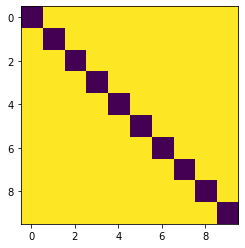

In [ ]:
plt.imshow(diff > 0)

In [ ]:
from AdversarialExamples import adversarial_example

# cnt = 0
idx = np.full(10, -1, dtype=int)
for i, data in enumerate(testset):
    # cnt += 1
    # if cnt < 1000: continue
    input, label = data
    with torch.no_grad():
        local_pred = local_net.forward_pass(input.reshape(1, -1)).argmax()
        # gd_pred = gd_net.forward_pass(input.reshape(1, -1)).argmax()
        # if local_pred == label and gd_pred == label and idx[label] < 0:
        if local_pred == label and idx[label] < 0:
            idx[label] = i
    if np.all(idx >= 0):
        print('Appropriate samples found')
        break

Appropriate samples found


In [ ]:
idx

array([ 3,  2,  1, 18,  4, 23, 21,  0, 61,  7])

In [ ]:
inputs = []
for i in idx:
    data = testset[i]
    input, label = data
    inputs += [input.reshape(1, -1)]
inputs = torch.cat(inputs, dim=0)
print(inputs.shape)

torch.Size([10, 784])


In [ ]:
local_adv_ex = torch.Tensor(10, 10, 784)
gd_adv_ex = torch.Tensor(10, 10, 784)
for i in range(10):
    for j in range(10):
        print(j)
        if i == j:
            local_adv_ex[i, j] = inputs[i].squeeze()
            gd_adv_ex[i, j] = inputs[i].squeeze()
        else:
            local_adv_ex[i, j] = adversarial_example(inputs[i].reshape(1, -1), torch.tensor([j], dtype=torch.long), local_net.forward_pass, eps = 4, lr=1e-3)
            gd_adv_ex[i, j] = adversarial_example(inputs[i].reshape(1, -1), torch.tensor([j], dtype=torch.long), gd_net.forward_pass, eps = 4, lr=1e-3)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


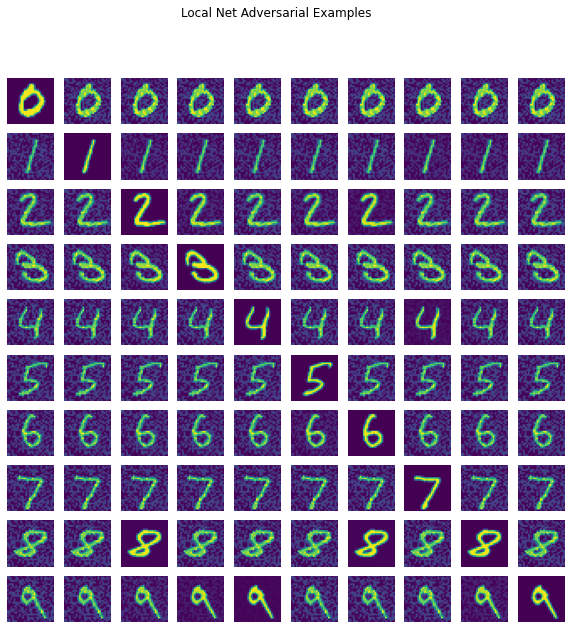

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j, ax in enumerate(axes[i]):
        ax.imshow(local_adv_ex[i, j].detach().reshape(28, 28), vmin=0, vmax=1)
        ax.set_axis_off()
        
fig.suptitle('Local Net Adversarial Examples')
plt.savefig('local_net_adversarial_t=2.png')

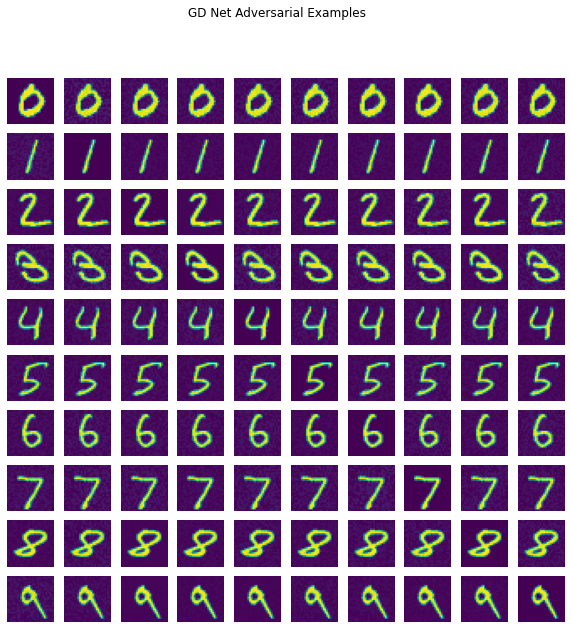

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j, ax in enumerate(axes[i]):
        ax.imshow(gd_adv_ex[i, j].detach().reshape(28, 28), vmin=0, vmax=1)
        ax.set_axis_off()
        
fig.suptitle('GD Net Adversarial Examples')
plt.savefig('gd_net_adversarial_t=2.png')

In [ ]:
local_mag = torch.norm(inputs.reshape(1, 10, -1) - local_adv_ex.detach(), dim=-1)
gd_mag = torch.norm(inputs.reshape(1, 10, -1) - gd_adv_ex.detach(), dim=-1)

width = 0.35
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(np.arange(10) - width/2, local_mag.mean(dim=0), width=width, label='Local', color='red')
axes[0].bar(np.arange(10) + width/2, gd_mag.mean(dim=0), width=width, label='GD', color='blue')
axes[0].set_xticks(np.arange(10))
axes[0].set_title('Mean corruption to achieve adversarial label')

axes[1].bar(np.arange(10) - width/2, (local_mag + torch.eye(10) * 100).min(dim=0)[0], width=width, label='Local', color='red')
axes[1].bar(np.arange(10) + width/2, (gd_mag + torch.eye(10) * 100).min(dim=0)[0], width=width, label='GD', color='blue')
axes[1].set_xticks(np.arange(10))
axes[1].set_title('Min corruption to achieve adversarial label')

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
options.use_graph_rule = True
options.additive_rule = False 

meta_model = LocalNetOutputMultiRuleModel(784, 10, num_v = 200, p = .5, cap = 100, rounds = 2, step_sz=1e-3, options = options)
# meta_model.input_weights = torch.ones_like(meta_model.input_weights)
meta_model.set_output_rule(torch.tensor([[-1,1],[1,-1],[-1,1],[1,-1],[-1,1],[1,-1],[-1,1],[1,-1]]))
optimizer = torch.optim.Adam(meta_model.graph_rule_model.parameters(), lr=1e-3)
losses = []

In [ ]:
for i in range(5):
    for j, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()

        loss = meta_model(inputs, labels, 1, 1)
        loss.backward()
        optimizer.step()
        losses += [loss.item()]
        if j % 1 == 0:
            if j % 10 == 0:
              local_correct = 0
              with torch.no_grad():
                  for inputs, labels in testloader:
                      outputs = meta_model.forward_pass(inputs)
                      local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
              print('Local Net Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))
              # local_correct = 0
              # with torch.no_grad():
              #     for inputs, labels in trainloader:
              #         outputs = meta_model.forward_pass(inputs)
              #         local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
              # print('Local Net Train Accuracy: {:.3f}%'.format(local_correct / len(trainset) * 100))

            print('{:d} {:d}: {:.3f}'.format(i, j, loss.item()))

Local Net Test Accuracy: 32.590%
0 0: 4173.702
0 1: 3453.225
0 2: 1695.563
0 3: 2886.515
0 4: 1962.389
0 5: 2425.792
0 6: 5240.254
0 7: 5698.057
0 8: 3291.025
0 9: 2327.781
Local Net Test Accuracy: 36.800%
0 10: 2813.717
0 11: 2447.752
0 12: 1762.304
0 13: 5112.839
0 14: 1015.786
0 15: 2059.997
0 16: 3273.249
0 17: 1455.061
0 18: 1938.044
0 19: 1376.642
Local Net Test Accuracy: 35.650%
0 20: 2002.366
0 21: 2183.877
0 22: 1342.878
0 23: 2661.454
0 24: 2532.614
0 25: 2296.716
0 26: 1712.885
0 27: 1338.655
0 28: 1518.717
0 29: 2321.517
Local Net Test Accuracy: 40.650%
0 30: 1467.629
0 31: 1928.898
0 32: 1843.036
0 33: 1745.169
0 34: 1379.856
0 35: 1615.862
0 36: 2285.779
0 37: 2498.644
0 38: 881.316
0 39: 1179.182
Local Net Test Accuracy: 39.640%
0 40: 1145.774
0 41: 1657.797
0 42: 1581.753
0 43: 1997.196
0 44: 1183.213
0 45: 883.190
0 46: 1728.719
0 47: 736.737
0 48: 1874.222
0 49: 1465.948
Local Net Test Accuracy: 44.090%
0 50: 1189.505
0 51: 1092.587
0 52: 1000.530
0 53: 1052.451
0 54:

KeyboardInterrupt: ignored

In [ ]:
print(meta_model.graph_rule_model(torch.tensor([0,0,0,0]).double()))
print(meta_model.graph_rule_model(torch.tensor([0,1,0,0]).double()))
print(meta_model.graph_rule_model(torch.tensor([1,0,0,0]).double()))
print(meta_model.graph_rule_model(torch.tensor([1,1,0,0]).double()))

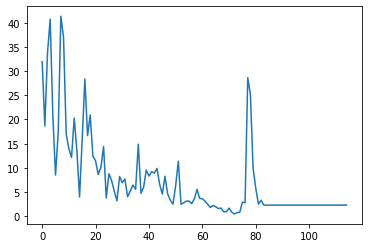

In [ ]:
fig, ax = plt.subplots()
ax.plot(losses)

In [ ]:
local_correct = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = meta_model.forward_pass(inputs)
        local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('Local Net Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))

In [ ]:
meta_model1 = LocalNetOutputMultiRuleModel(784, 10, num_v = 1000, p = .5, cap = 500, rounds = 2, step_sz=1e-3, options = options)
# meta_model.input_weights = torch.ones_like(meta_model.input_weights)
meta_model1.set_output_rule(torch.tensor([[-1,1],[1,-1],[-1,1],[1,-1],[-1,1],[1,-1],[-1,1],[1,-1]]))
meta_model1.graph_rule_model = meta_model.graph_rule_model

meta_model1.graph_weights = torch.zeros_like(meta_model1.graph_weights)
meta_model1.output_weights = torch.zeros_like(meta_model1.output_weights)
# meta_model1.update_scheme.update_misclassified_only = False
meta_model1.step_sz = 1e-5
with torch.no_grad():
    for i in range(15):
        for j, data in enumerate(trainloader):
            inputs, labels = data
            if i == 0 and j == 0:
                continue_ = False
            else:
                continue_ = True
            loss = meta_model1(inputs, labels, 1, 1, continue_=continue_)
            losses += [loss.item()]

            
            if j % 1 == 0:
                print('{:d} {:d}: {:.3f}'.format(i, j, loss.item()))

                local_correct = 0

                if j % 10 == 0:
                  with torch.no_grad():
                      for inputs, labels in trainloader:
                          outputs = meta_model1.forward_pass(inputs)
                          local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
                  print('Local Net Train Accuracy: {:.3f}%'.format(local_correct / len(trainset) * 100))

0 0: 49.883
Local Net Train Accuracy: 53.637%
0 1: 131.333
0 2: 147.534
0 3: 55.929
0 4: 154.417
0 5: 357.911
0 6: 75.036
0 7: 42.486
0 8: 130.219
0 9: 29.460
0 10: 155.175
Local Net Train Accuracy: 66.258%
0 11: 69.889
0 12: 130.936
0 13: 286.432
0 14: 83.751
0 15: 31.100
0 16: 64.703
0 17: 156.599
0 18: 52.828
0 19: 140.750
0 20: 73.130
Local Net Train Accuracy: 77.623%
0 21: 96.000
0 22: 120.517
0 23: 153.898
0 24: 164.924
0 25: 153.347
0 26: 110.141
0 27: 134.171
0 28: 79.007
0 29: 215.688
0 30: 235.227
Local Net Train Accuracy: 71.227%
0 31: 123.399
0 32: 92.619
0 33: 89.576
0 34: 48.006
0 35: 65.041
0 36: 32.431
0 37: 72.097
0 38: 42.623
0 39: 38.438
0 40: 101.207
Local Net Train Accuracy: 78.930%
0 41: 103.168
0 42: 51.613
0 43: 62.336
0 44: 111.098
0 45: 109.610
0 46: 84.520
0 47: 48.872
0 48: 95.243
0 49: 105.211
0 50: 70.342
Local Net Train Accuracy: 80.580%
0 51: 89.430
0 52: 71.614
0 53: 49.438
0 54: 96.824
0 55: 72.506
0 56: 126.315
0 57: 46.953
0 58: 58.534
0 59: 86.566
0

KeyboardInterrupt: ignored

In [ ]:
local_correct = 0

with torch.no_grad():
    for inputs, labels in trainloader:
        outputs = meta_model1.forward_pass(inputs)
        local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('Local Net Train Accuracy: {:.3f}%'.format(local_correct / len(trainset) * 100))

Local Net Train Accuracy: 86.175%


In [ ]:
local_correct = 0

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = meta_model1.forward_pass(inputs)
        local_correct += np.count_nonzero((outputs.argmax(axis=1) == labels).numpy())
print('Local Net Test Accuracy: {:.3f}%'.format(local_correct / len(testset) * 100))

Local Net Test Accuracy: 85.370%


In [ ]:
np.savez_compressed('models/localnet_mnist_rnn_outputrule.npz', 
                    input_weights=local_net.input_weights.numpy(), 
                    graph_weights=local_net.graph_weights.numpy(),
                    output_weights=local_net.output_weights.numpy())

In [ ]:
np.savez_compressed('models/gdnet_mnist_rnn_outputrule.npz', 
                    input_weights=gd_net.input_weights.detach().numpy(), 
                    graph_weights=gd_net.graph_weights.detach().numpy(),
                    output_weights=gd_net.output_weights.detach().numpy())